# Topics in Cloud and Environment (2019)

## Example: Feature Selection

---

The classes in the [`sklearn.feature_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. For further details, please visit the [reference](https://scikit-learn.org/stable/modules/feature_selection.html).

Take regression as example, feature selection can be done either forward or backward. The forward approach adds variables one-by-one, while the backward approach eliminate variables one by one.

Here we are using the logistic regression as an example to work with a few feature selection methods.

### Load data

First, we use the 10-day sums of weather events as X, and the air-polution event as Y.

In [1]:
# Load library
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFECV

# Load data
y = pd.read_csv('../data/ap_events_2005-2014.csv',  index_col=0)
x = pd.read_csv('../data/weather_event_10day_sums_2005-2014.csv', index_col=0)
X = np.array(x)
Y = np.array(y).flatten()
print('Data dimension: ')
print(X.shape)
print(Y.shape)
print('Variables')
print(list(x.columns))

Data dimension: 
(3652, 13)
(3652,)
Variables
['CS', 'FT', 'NE', 'SNE', 'SWF', 'SSWF', 'TYW', 'TC100', 'TC200', 'TC300', 'TC500', 'TC1000', 'NWPTY']


### Basic Logistic Regression

Then, we use X to predict Y using logistic regression as shown in [earlier example](https://github.com/tingsyo/course_ce2019/blob/master/week04_generalized_linear_model/Generalized_Linear_Model.ipynb).

In [2]:
import statsmodels.api as sm

# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(X, Y)
yhat_glm = glm.predict(X)

# Metrics function for reuse
def evaluate_model(y_true, y_pred):
    # Create confusion matrix
    cfm = pd.crosstab(y_true, y_pred, rownames=['Truth'], colnames=['Prediction'])
    # Create report
    from sklearn.metrics import accuracy_score, classification_report
    cr = classification_report(y_true, y_pred)
    return({'matrix':cfm, 'report':cr})

# Show results
cfm = evaluate_model(Y, yhat_glm)
print(cfm['matrix'])
print()
print(cfm['report'])

# Comprehensive evaluation
glmsm = sm.Logit(Y, X)
glmsm.fit(maxiter=30).summary()

Prediction     0    1
Truth                
0           2685   97
1            746  124

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2782
           1       0.56      0.14      0.23       870

   micro avg       0.77      0.77      0.77      3652
   macro avg       0.67      0.55      0.55      3652
weighted avg       0.73      0.77      0.71      3652

Optimization terminated successfully.
         Current function value: 0.430722
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3652
Model:                          Logit   Df Residuals:                     3639
Method:                           MLE   Df Model:                           12
Date:                Mon, 27 May 2019   Pseudo R-squ.:                  0.2155
Time:                        17:17:22   Log-Likelihood:                -1573.0
converged:                       True   LL-Null:                       -2005.0
                                        LLR p-value:                2.935e-177
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0319      0.067     -0.475      0.635      -0.164       0.100
x2            -0.1573      0.024     -6.474      0.000      -0.205      -0.110
x3             0.1157      0.031      3.705      0.000       0.054       0.177
x4            -0.1716      0.037     -4.654      0.000      -0.244      -0.099
x5            -0.2827      0.045     -6.311      0.000      -0.370      -0.195
x6            -0.3947      0.107     -3.684      0.000      -0.605      -0.185
x7             0.1172      0.152      0.771      0.441      -0.181       0.415
x8            -0.7848      0.307     -2.558      0.011      -1.386      -0.183
x9             0.7252      0.289      2.512      0.012       0.159       1.291
x10            0.2897      0.257      1.129      0.259      -0.213       0.793
x11            0.0595      0.153      0.387      0.698      -0.241       0.360
x12           -0.3517      0.050     -6.987      0.000      -0.450      -0.253
x13           -0.0347      0.014     -2.463      0.014      -0.062      -0.007
==============================================================================
"""

### Selec features based on GLM summary

Next, let's see if we select features based on it's p-value in the GLM summary.

In [3]:
pv05 = [1,2,3,4,5,7,8,11]
x_pv = X[:, pv05]
print(x_pv.shape)
# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(x_pv, Y)
yhat = glm.predict(x_pv)

# Show results
cfm = evaluate_model(Y, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

(3652, 8)
Prediction     0   1
Truth               
0           2704  78
1            776  94

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2782
           1       0.55      0.11      0.18       870

   micro avg       0.77      0.77      0.77      3652
   macro avg       0.66      0.54      0.52      3652
weighted avg       0.72      0.77      0.70      3652



### Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the `transform` method:

- [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) removes all but the $k$ highest scoring features
- [`SelectPercentile`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html) removes all but a user-specified highest scoring percentage of features
- using common univariate statistical tests for each feature: false positive rate [`SelectFpr`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFpr.html), false discovery rate [`SelectFdr`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html), or family wise error [`SelectFwe`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFwe.html).
- [`GenericUnivariateSelect`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html) allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.

These objects take as input a scoring function that returns univariate scores and p-values:

- For regression: [`f_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), [`mutual_info_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)
- For classification: [`chi2`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html), [`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html), [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

In the following example, we use [`mutual information`](https://en.wikipedia.org/wiki/Mutual_information) to select top 60% of features. Please feel free to use a different selection method or scores and compare the results with the full-feature model above.

In [4]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

newx = SelectPercentile(mutual_info_classif, percentile=60).fit_transform(X, Y)
print(newx.shape)

# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(newx, Y)
yhat = glm.predict(newx)

# Show results
cfm = evaluate_model(Y, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

(3652, 8)
Prediction     0    1
Truth                
0           2684   98
1            754  116

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      2782
           1       0.54      0.13      0.21       870

   micro avg       0.77      0.77      0.77      3652
   macro avg       0.66      0.55      0.54      3652
weighted avg       0.72      0.77      0.71      3652



### Recursive feature elimination with cross-validation

A recursive feature elimination example with automatic tuning of the number of features selected with cross-validation. We need to specify a [`scoing metric`](https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation) for the automatic selection process. Here we simply use *accuracy* of the classification as the criteria.

- [note] This example took ~3 seconds on an Intel i7-7920H CPU with 16GB system memory, so please expect to wait for a few seconds, it's normal.

Optimal number of features : 4


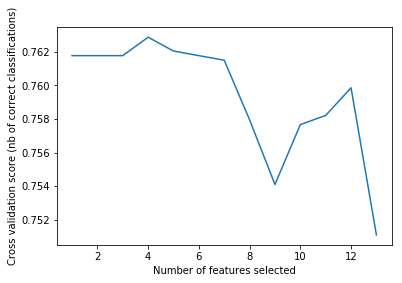

In [5]:
# Reference: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=glm, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

As shown above, RFE with 10-fold CV suggested that we use 4 features, which are:

In [6]:
x_sel = list(x.columns[rfecv.support_])
print(x_sel)

['SSWF', 'TC100', 'TC200', 'TC300']


If we look at the GLM model summary, the choice of RFE does not match with the selection by *p-value*. So, let's see the perfromance of using these 4 features only.

In [7]:
x_rfe = np.array(x.loc[:,x_sel])
print(x_rfe.shape)
# Fit the classifier
glm = LogisticRegression(C=1e5, solver='lbfgs', max_iter=500)
glm.fit(x_rfe, Y)
yhat = glm.predict(x_rfe)

# Show results
cfm = evaluate_model(Y, yhat)
print(cfm['matrix'])
print()
print(cfm['report'])

(3652, 4)
Prediction     0
Truth           
0           2782
1            870

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2782
           1       0.00      0.00      0.00       870

   micro avg       0.76      0.76      0.76      3652
   macro avg       0.38      0.50      0.43      3652
weighted avg       0.58      0.76      0.66      3652



/Users/tsyo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tsyo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tsyo/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As shown in the example, the feature selection methods don't always work. This could be mainly caused by our choice of feature set (weather events) and model (logistic regression). We can achieve better results if we change our choice.